In [1]:
# Import packages and datasets
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from matplotlib import offsetbox
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# 全局取消证书验证
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
# 导入数据集
sets = datasets.fetch_olivetti_faces(shuffle=True)
faces = sets.data
target = sets.target
print(faces.shape, target.shape)

(400, 4096) (400,)


In [3]:
# 绘图
def plot_gallery(title, images, n_col, n_row, cmap=plt.cm.gray):
    plt.figure(figsize=(2.0 * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(
            comp.reshape(64, 64),
            cmap=cmap,
            interpolation="nearest",
            vmin=-vmax,
            vmax=vmax,
        )
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.0)

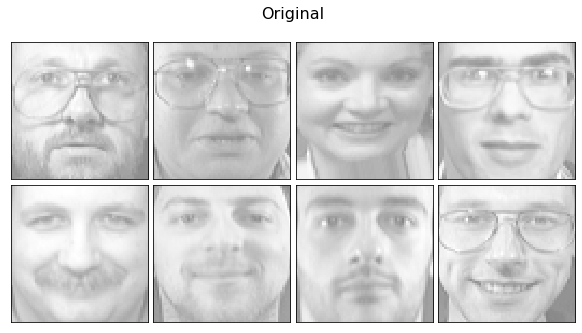

In [4]:
plot_gallery('Original', faces[:8], 4, 4)

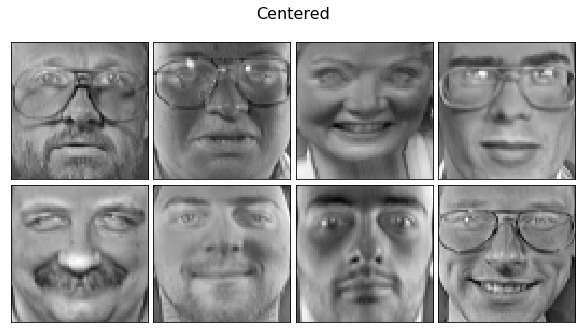

In [5]:
# 中心化
faces_centered = faces - np.average(faces, axis=0)
plot_gallery('Centered', faces_centered[:8], 4, 4)

In [6]:
# PCA
# Compute Covariance Matrix
Cov = (1 / len(faces)) * np.dot(faces_centered.T, faces_centered)
lbd, W = np.linalg.eig(Cov)
idx = lbd.argsort()[::-1]
lbd = lbd[idx]
W = W[:, idx]
print(lbd)

[ 1.8793076e+01  1.1044083e+01  6.2888532e+00 ... -1.2312763e-07
 -1.2414586e-07 -1.2440418e-07]


0.9353533


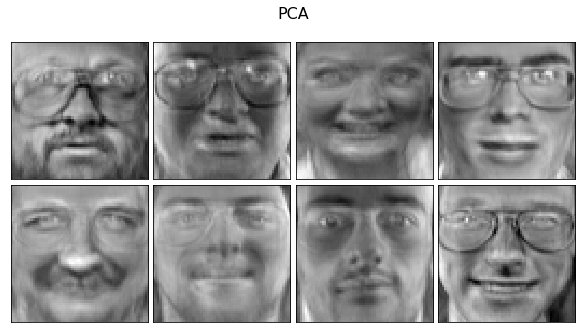

In [7]:
# Compute Variance Contribution Rate
R = np.sum(lbd[:100]) / np.sum(lbd)
print(R)
# Re-Build
W_PCA = W[:, :100]
Y = np.transpose(np.dot(W_PCA.T, faces_centered.T))
rebuild = np.dot(Y, W_PCA.T)
plot_gallery('PCA', rebuild[:8], 4, 4)

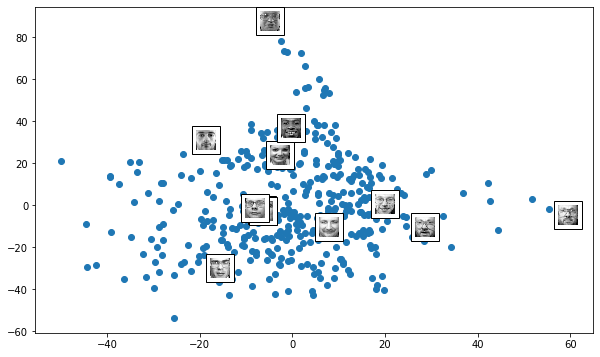

In [8]:
# 2D Visible Plot
tmp = faces_centered.dot(rebuild.T)[:,:2]
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(tmp[:,0],tmp[:,1])
for i in range(12):
    imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(cv2.resize(faces[i].reshape([64,64]),[20,20]), cmap=plt.cm.gray), tmp[i])
    imagebox.set(zorder=1)
    ax.add_artist(imagebox)

In [47]:
# Train & Test PCA
def PCA(X, X_test, num):
    # Centered
    XC = X - np.average(X, axis=0)
    XC_test = X_test - np.average(X_test, axis=0)
    # Compute Covariance Matrix
    Cov = (1 / len(X)) * np.dot(XC.T, XC)
    lbd, W = np.linalg.eig(Cov)
    print(lbd)
    # Compute Variance Contribution Rate
    R = np.sum(lbd[:num]) / np.sum(lbd)
    print(R)
    # Re-Build
    W_PCA = W[:, :num]
    train = XC.dot(W_PCA)
    test = XC_test.dot(W_PCA)
    return train, test
# def PCA(X, num):
#     # Centered
#     mean = np.average(X, axis=0)
#     XC = X - mean
#     # Compute Covariance Matrix
#     Cov = (1 / len(X)) * np.dot(XC, XC.T)
#     lbd, W = np.linalg.eig(Cov)
#     # print(lbd)
#     # Compute Variance Contribution Rate
#     R = np.sum(lbd[:num]) / np.sum(lbd)
#     print(R)
#     # Re-Build
#     W_PCA = W[:, :num]
#     rebuild = np.transpose(np.dot(XC.T, W_PCA).dot(np.sqrt(np.diag(lbd[:num]))))
#     plot_gallery('temp', rebuild[:8],4 ,4)
#     print(XC.shape, W.shape)
#     return Y
data_train, data_test, taregt_train, target_test = train_test_split(faces, target, test_size=0.3, random_state=42)
data_pca_train, data_pca_test = PCA(data_train, data_test, 80)
data_pca_train.shape, data_pca_test.shape

[ 1.7321543e+01  1.1655077e+01  6.1398959e+00 ...  4.7314384e-09
  4.5944395e-09 -5.6039324e-09]
0.9286757


((280, 80), (120, 80))

In [48]:
# Find Parameters
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10)
clf = clf.fit(data_pca_train, taregt_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

/Users/muuu/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best estimator found by grid search:
SVC(C=23962.25695883368, class_weight='balanced', gamma=0.0007329329266989896)


In [50]:
# Accuracy
acc = clf.score(data_pca_test, target_test)
print("The Classification Accuracy is %.2f%%." %(acc * 100))

The Classification Accuracy is 93.33%.
